In [1]:
import os
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patheffects import Normal, Stroke
import numpy as np
import seaborn as sns
from ezephys import pltools

import memorize

In [2]:
def savefig(fname, **pltargs):
    plt.savefig(fname + '.png', dpi=300, bbox_inches='tight', **pltargs)
    plt.savefig(fname + '.svg', dpi=300, bbox_inches='tight', **pltargs)

In [3]:
memorize.torch.manual_seed(42)

DEMO_NET = 'BAP'
FIGURE_WIDTH = 7

demo_net_before_train = memorize.get_networks()[DEMO_NET]
demo_net_after_train = deepcopy(demo_net_before_train)
demo_optimizer = memorize.get_optimizers({DEMO_NET: demo_net_after_train})[DEMO_NET]
demo_x, demo_y = memorize.generate_data()

demo_optimizer.optimize(demo_x, demo_y, memorize.EPOCHS, progress_bar='notebook')

  0%|          | 0/600 [00:00<?, ?it/s]

In [4]:
def tensor_to_events(tensor):
    return [np.nonzero(tensor[i, :]).flatten() for i in range(tensor.shape[0])]

def _visual_spike(voltage, spikes, spike_height=50):
    assert voltage.shape == spikes.shape
    voltage = deepcopy(voltage)
    voltage[spikes > 0.0] = spike_height
    return voltage

def plot_voltage_with_spikes(recorder, example_nb: int, unit_nb: int, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(
        _visual_spike(
            recorder.recorded['somatic_subunit.linear'][example_nb, :, unit_nb].detach().numpy(),
            recorder.recorded['output'][example_nb, :, unit_nb].detach().numpy()
        ),
        **pltargs
    )

y_palette = {0: 'xkcd:violet', 1: 'xkcd:forest green'}

/home/efharkin/.miniconda3/envs/lnldend/lib/python3.8/site-packages/numpy/core/fromnumeric.py:58: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /tmp/pip-req-build-ojg3q6e4/torch/csrc/utils/python_arg_parser.cpp:882.)
  return bound(*args, **kwds)


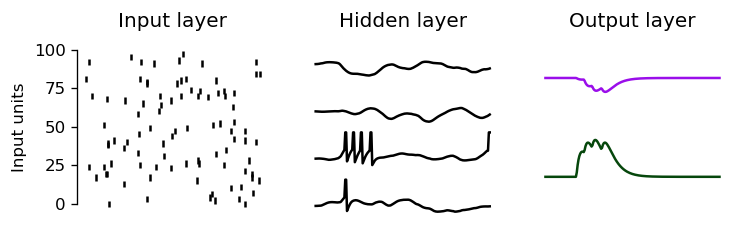

In [5]:
spec_outer = gs.GridSpec(1, 3)
spec_hidden = gs.GridSpecFromSubplotSpec(demo_net_before_train.nb_units_by_layer[1], 1, spec_outer[:, 1])
spec_output = gs.GridSpecFromSubplotSpec(demo_net_before_train.nb_units_by_layer[2], 1, spec_outer[:, 2])

plt.figure(figsize=(FIGURE_WIDTH, 2), dpi=120)

plt.subplot(spec_outer[:, 0])
plt.title('Input layer')
plt.eventplot(tensor_to_events(demo_x[0, ...].T), linelengths=4, color='black')
plt.ylabel('Input units')
pltools.hide_border('trb', trim=True)

_, demo_activity = demo_net_before_train.run_snn(demo_x)

for i in range(demo_net_before_train.nb_units_by_layer[1]):
    plt.subplot(spec_hidden[i, :])
    plot_voltage_with_spikes(demo_activity['l1'], 0, i, color='black', clip_on=False)
    plt.ylim(-23, 52)
    
    if i == 0:
        plt.title('Hidden layer')
    
    pltools.hide_border()
    
for i in range(demo_net_before_train.nb_units_by_layer[2]):
    plt.subplot(spec_output[i, :])
    plt.plot(
        demo_activity['l2'].recorded['output'][0, :, i].detach().numpy(),
        color=y_palette[i],
        clip_on=False
    )
    plt.ylim(-12, 12)
    
    if i == 0:
        plt.title('Output layer')
    
    pltools.hide_border()

savefig(os.path.join('..', 'data', 'single_example_BAP'))

del spec_outer, spec_hidden, spec_output, i

In [6]:
def predicted_label(recording, example_nb):
    return recording.recorded['output'][example_nb, ...].max(axis=0)[0].max(axis=0)[1]

def annotate_correctness(recording, labels, example_nb, ax=None):
    if ax is None:
        ax = plt.gca()
        
    if predicted_label(demo_activity['l2'], example_nb) == demo_y[i]:
        mark, color = '✓', 'green'
    else:
        mark, color = '✗', 'red'
        
    text = ax.text(1, 1, mark, color=color, transform=ax.transAxes, ha='center', va='top')
    text.set_path_effects([Stroke(linewidth=2, foreground='white'), Normal()])

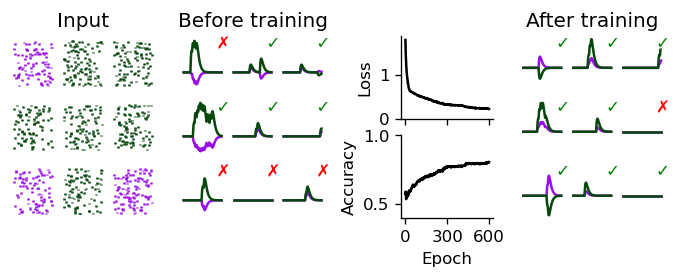

In [7]:
EXAMPLE_GRID_SHAPE = (3, 3)

spec_outer = gs.GridSpec(1, 4, hspace=0.2)
spec_input = gs.GridSpecFromSubplotSpec(*EXAMPLE_GRID_SHAPE, spec_outer[:, 0])
spec_before = gs.GridSpecFromSubplotSpec(*EXAMPLE_GRID_SHAPE, spec_outer[:, 1])
spec_loss = gs.GridSpecFromSubplotSpec(2, 2, spec_outer[:, 2], width_ratios=[0.4, 1])
spec_after = gs.GridSpecFromSubplotSpec(*EXAMPLE_GRID_SHAPE, spec_outer[:, 3])

plt.figure(figsize=(FIGURE_WIDTH, 2), dpi=120)

# Show input

for i in range(np.prod(EXAMPLE_GRID_SHAPE)):
    if i == 0:
        ax0 = plt.subplot(spec_input[i])
    else:
        plt.subplot(spec_input[i], sharey=ax0)
    plt.eventplot(tensor_to_events(demo_x[i, ...].T), linelengths=4, color=y_palette[int(demo_y[i])])
    pltools.hide_border()

    if i == EXAMPLE_GRID_SHAPE[0] // 2:
        plt.title('Input')

del ax0

# Show output before training

_, demo_activity = demo_net_before_train.run_snn(demo_x)

for i in range(np.prod(EXAMPLE_GRID_SHAPE)):
    if i == 0:
        ax0 = plt.subplot(spec_before[i])
    else:
        plt.subplot(spec_before[i], sharey=ax0)
    
    for j in range(demo_net_before_train.nb_units_by_layer[2]):
        plt.plot(
            demo_activity['l2'].recorded['output'][i, :, j].detach().numpy(),
            color=y_palette[j],
            clip_on=False
        )
    pltools.hide_border()
    
    annotate_correctness(demo_activity['l2'], demo_y, i)
    
    if i == EXAMPLE_GRID_SHAPE[0] // 2:
        plt.title('Before training')
    
# Show loss and accuracy

plt.subplot(spec_loss[0, 1])
plt.plot(demo_optimizer.loss_history, 'k-')
plt.xticks([0, 300, 600], ['', '', ''])
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Loss')
pltools.hide_border('tr')

plt.subplot(spec_loss[1, 1])
plt.plot(demo_optimizer.accuracy_history, 'k-')
plt.xticks([0, 300, 600])
plt.ylim(0.4, 1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
pltools.hide_border('tr')
    
# Show output after training

_, demo_activity = demo_net_after_train.run_snn(demo_x)


for i in range(np.prod(EXAMPLE_GRID_SHAPE)):
    if i == 0:
        ax0 = plt.subplot(spec_after[i])
    else:
        plt.subplot(spec_after[i], sharey=ax0)
    
    for j in range(demo_net_after_train.nb_units_by_layer[2]):
        plt.plot(
            demo_activity['l2'].recorded['output'][i, :, j].detach().numpy(),
            color=y_palette[j],
            clip_on=False
        )
    pltools.hide_border()
    
    if i == EXAMPLE_GRID_SHAPE[0] // 2:
        plt.title('After training')
        
    annotate_correctness(demo_activity['l2'], demo_y, i)
    
savefig(os.path.join('..', 'data', 'multi_example_BAP'))

# Performance comparison

Run `memorize.py` to train five different PRC models several times with different seeds. The loss and accuracy during training are saved to CSV files that we'll inspect here.

In [8]:
DATA_FILE_PREFIX = os.path.join('..', 'data', 'memorization_training_results_')

performance = []

for i in range(10):
    single_seed_performance = pd.read_csv(DATA_FILE_PREFIX + str(i) + '.csv')
    single_seed_performance['seed'] = i

    performance.append(single_seed_performance)

performance = pd.concat(performance).reset_index(drop=True)

In [9]:
performance.head()

,model_name,epoch,loss,accuracy,seed
0,One compartment,0,0.705004,0.468750,0
1,One compartment,1,0.702757,0.476562,0
2,One compartment,2,0.701307,0.480469,0
3,One compartment,3,0.698993,0.484375,0
4,One compartment,4,0.699142,0.476562,0


In [10]:
def performance_bandplot(model_name, metric_loss=True, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()

    if metric_loss:
        metric = 'loss'
    else:
        metric = 'accuracy'

    alpha = min(pltargs.pop('alpha', 1), 0.8)

    this_model = performance.query('model_name == @model_name').sort_values(
        'epoch'
    )
    if 'label' not in pltargs:
        pltargs['label'] = model_name

    this_std = (
        this_model.groupby(['model_name', 'epoch']).std().sort_values('epoch')
    )
    this_mean = (
        this_model.groupby(['model_name', 'epoch']).mean().sort_values('epoch')
    )

    label = pltargs.pop('label', None)
    maincolor = pltargs.pop('color', None)
    ax.fill_between(
        this_mean.index.get_level_values('epoch'),
        this_mean[metric] - this_std[metric],
        this_mean[metric] + this_std[metric],
        alpha=alpha,
        facecolor=maincolor,
        edgecolor='none',
        **pltargs
    )
    ax.plot(
        this_mean.index.get_level_values('epoch'),
        this_mean[metric],
        label=label,
        color=maincolor,
        **pltargs
    )

In [11]:
palette = {
    'One compartment': 'gray',
    'No BAP': 'xkcd:ocean',
    'BAP': 'xkcd:cherry',
    'Parallel subunits, no BAP': 'xkcd:iris',
    'Parallel subunits + BAP (full PRC model)': 'xkcd:blood orange'
}

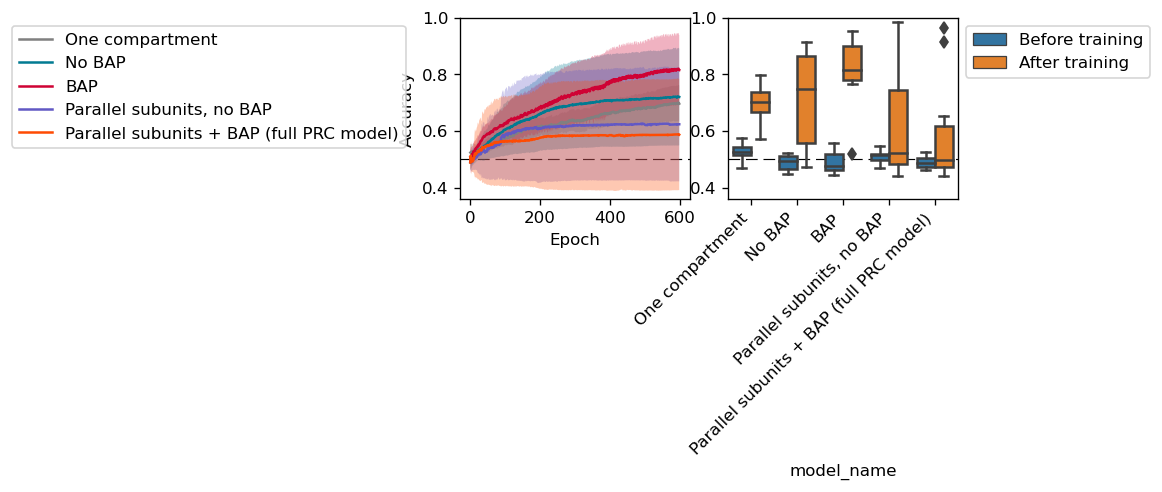

In [12]:
spec_outer = gs.GridSpec(1, 3, width_ratios=(0.5, 1, 1))

plt.figure(figsize=(FIGURE_WIDTH, 2), dpi=120)

plt.subplot(spec_outer[:, 1])
plt.axhline(0.5, color='k', ls='--', dashes=(10, 5), lw=0.7, zorder=-1)
for model_name, colour in palette.items():
    this_mean = performance_bandplot(
        model_name, metric_loss=False, color=colour, alpha=0.3
    )
plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.36, 1)

plt.subplot(spec_outer[:, 2])
plt.axhline(0.5, color='k', ls='--', dashes=(10, 5), lw=0.7, zorder=-1)
box_data = performance.query('epoch in [0, 599]').copy()
box_data.loc[:, 'Epoch'] = box_data.epoch.astype(str)
box_data.replace('0', 'Before training', inplace=True)
box_data.replace('599', 'After training', inplace=True)
sns.boxplot(
    x='model_name',
    y='accuracy',
    hue='Epoch',
    data=box_data,
)
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')
plt.ylabel('')
plt.ylim(0.36, 1)

savefig(os.path.join('..', 'data', 'performance_comparison'))
plt.show()